<a href="https://colab.research.google.com/github/bluepsm/sentiment-analysis-twitter/blob/main/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis on Tweets

**Objective:** Classify tweets as positive, negative, or neutral.

**Skills:** Natural Language Processing (NLP), text preprocessing, sentiment analysis, word embeddings, neural networks (e.g., LSTM).

In [228]:
# @title Import library
import chardet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import html
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [229]:
#@title Find encoding of dataset
# with open('/content/drive/MyDrive/datasets/twitter/twitter.csv', 'rb') as f:
#   encoding = chardet.detect(f.read())

# encoding['encoding']

In [230]:
#@title Import dataset
colnames = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv('/content/drive/MyDrive/datasets/twitter/twitter.csv', names=colnames, encoding='Windows-1252')

dataset = dataset.sample(n=20000, random_state=42)

sentiment = {0: 'negative', 4: 'positive'}
dataset['target'] = dataset['target'].map(sentiment)

dataset.sample(10)

,target,id,date,flag,user,text
1284594,positive,2002061135,Tue Jun 02 03:00:46 PDT 2009,NO_QUERY,leemack912,@augustagaliving Goood Morning
337778,negative,2014286533,Wed Jun 03 01:02:01 PDT 2009,NO_QUERY,Sprookje,still a bit shaky from the confrontation with ...
504917,negative,2188256979,Mon Jun 15 21:34:15 PDT 2009,NO_QUERY,gypsypleasure,I feel like I'm drowning without water.
1255115,positive,1997217672,Mon Jun 01 16:27:46 PDT 2009,NO_QUERY,karenisnt,@kaitiecg :awesome: i'll add you then?
696312,negative,2253490410,Sat Jun 20 08:15:28 PDT 2009,NO_QUERY,Taylorrr_Taylor,aww leaving before i get to check twitter!
930490,positive,1760358225,Sun May 10 21:19:14 PDT 2009,NO_QUERY,theanykey,@canadianfamily The best thing about my Mother...
410152,negative,2059811832,Sat Jun 06 17:41:07 PDT 2009,NO_QUERY,BloodGutsGlory,@golftippin early goal out for vacation stay...
659561,negative,2242189899,Fri Jun 19 11:52:58 PDT 2009,NO_QUERY,KidKJ_21,@JessiDavis_ im so sick of charles barkley! I ...
1549536,positive,2183476568,Mon Jun 15 14:33:29 PDT 2009,NO_QUERY,strawberryland,I'm so excited now these next two weeks...
1128786,positive,1975410285,Sat May 30 15:05:55 PDT 2009,NO_QUERY,countrymusiclvr,@tonfue hey ther hun &lt;3 sorry but i gtg...i...


## Dataset overview

In [231]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 541200 to 517910
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  20000 non-null  object
 1   id      20000 non-null  int64 
 2   date    20000 non-null  object
 3   flag    20000 non-null  object
 4   user    20000 non-null  object
 5   text    20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


In [232]:
dataset['flag'].value_counts()

flag
NO_QUERY    20000
Name: count, dtype: int64

In [233]:
dataset['target'].value_counts()

target
positive    10058
negative     9942
Name: count, dtype: int64

## Prepocessing dataset

In [234]:
#@title Drop columns
dataset_backup = dataset.copy()

dataset = dataset.drop(['id', 'date', 'flag', 'user'], axis=1)

dataset.sample(10)

,target,text
805234,positive,@danishkanavin no the idiot who took it
1148989,positive,@CRAZi3B3AUTiFUL kay thanks!
1341683,positive,Going to Narnia to get lost! Yippie
1523260,positive,is too temperamental for her own good.=/ anywa...
1267376,positive,yay i have over 800 updates
348329,negative,I miss The Hills!
987237,positive,@melbgirl It means the same to us! #GoCats
548567,negative,Going To Bed ...My Ankle Hurts
803974,positive,"@donnyosmond Greetings from Cardiff, UK."
899205,positive,@smata i went to boston market. its delicious


In [235]:
#@title Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(dataset['text'], dataset['target'], test_size=0.25, random_state=42)

In [236]:
x_train.head(5)

1473410    Me and Lace coming out of mango tree resturant...
1021177    @shereemcfly09 yeah its going to be freaking a...
958067     @MoBostock be sure to twitpic some party pictu...
621438     Oh shitttt there's still tickets to see demi l...
1289024    @aycstacy I love it. I wanna blog. Ill buy my ...
Name: text, dtype: object

In [237]:
y_train.head(5)

1473410    positive
1021177    positive
958067     positive
621438     negative
1289024    positive
Name: target, dtype: object

In [238]:
x_train.info()

<class 'pandas.core.series.Series'>
Index: 15000 entries, 1473410 to 737335
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
15000 non-null  object
dtypes: object(1)
memory usage: 234.4+ KB


In [239]:
x_test.info()

<class 'pandas.core.series.Series'>
Index: 5000 entries, 595842 to 602979
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
5000 non-null   object
dtypes: object(1)
memory usage: 78.1+ KB


In [240]:
y_train.value_counts()

target
positive    7531
negative    7469
Name: count, dtype: int64

In [241]:
y_test.value_counts()

target
positive    2527
negative    2473
Name: count, dtype: int64

### Clean text

In [242]:
#@title Define function for text cleaning
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('vader_lexicon')

# Initialize stopwords, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  text = html.unescape(text)

  # Remove tags
  text = re.sub(r'@[A-Za-z0-9-_]+', '', text)

  # Remove links
  text = re.sub(r'(https?:\/\/|www\.)\S+', '', text)

  # Remove special characters and numbers
  text = re.sub(r'[^A-Za-z\s]', '', text)

  # Convert text to lowercase
  text = text.lower()

  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stopwords
  tokens = [word for word in tokens if word not in stop_words]

  # Apply stemming or lemmatization
  # tokens = [stemmer.stem(word) for word in tokens]  # For stemming
  tokens = [lemmatizer.lemmatize(word) for word in tokens]  # For lemmatization

  clean_text = ' '.join(tokens)

  return clean_text

# sample_text = "This is an example sentence from @Hello_world44, demonstrating text cleaning in Python! Please visit https://mockupsite.com/ for more examples&amp;tutorials!"
# cleaned_sample_text = clean_text(sample_text)

# cleaned_sample_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [243]:
x_train.head(10)

1473410    Me and Lace coming out of mango tree resturant...
1021177    @shereemcfly09 yeah its going to be freaking a...
958067     @MoBostock be sure to twitpic some party pictu...
621438     Oh shitttt there's still tickets to see demi l...
1289024    @aycstacy I love it. I wanna blog. Ill buy my ...
1080438    @officiallmiley ok.when you text them could yo...
248279     @AmiraEzeldin  wish i had been there. And at t...
387726                                             Headache 
1460144    Is eagerly waiting for the Twilight New Moon.....
1296714    @BravoBride The link didn't display, could you...
Name: text, dtype: object

In [244]:
#@title Cleaning text in dataset
x_train_backup = x_train.copy()
x_test_backup = x_test.copy()

x_train = x_train.apply(clean_text)
x_test = x_test.apply(clean_text)

x_train.head(10)

1473410    lace coming mango tree resturant last year pap...
1021177    yeah going freaking awesome upto much loveyouj...
958067              sure twitpic party picture give u detail
621438     oh shitttt there still ticket see demi lovato ...
1289024                      love wan na blog ill buy camera
1080438    okwhen text could ask post ur name account acc...
248279                       wish moment really missing babe
387726                                              headache
1460144           eagerly waiting twilight new moon twilight
1296714         link didnt display could repost correct link
Name: text, dtype: object

### Converting text into vectors

In [245]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

x_train_vec

<15000x16895 sparse matrix of type '<class 'numpy.int64'>'
	with 103029 stored elements in Compressed Sparse Row format>

##NLTK sentiment analyzer

In [246]:
#@title Define function
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
  scores = analyzer.polarity_scores(text)

  sentiment = 'positive' if scores['compound'] >= 0.05 else ('negative' if scores['compound'] <= -0.05 else 'neutral')

  return sentiment

In [247]:
#@title Call function
sentiment_from_analyzer = pd.DataFrame(columns=['text', 'target_sentiment', 'sentiment'])
sentiment_from_analyzer['text'] = x_test_backup
sentiment_from_analyzer['target_sentiment'] = y_test
sentiment_from_analyzer['sentiment'] = x_test.apply(get_sentiment)

sentiment_from_analyzer.sample(10)

,text,target_sentiment,sentiment
367949,i don't know what to tweet about,negative,neutral
596005,off to bed... not feeling too great,negative,positive
288957,Sadly I have to go back to work tomorrow stil...,negative,negative
1384339,Wow! #ubuntu wish me Happy Birthday!,positive,positive
1348100,friends tomorrow we wil rock the Club ;D,positive,positive
1159337,@sambriones sammmmyy... advil lang.. it works ...,positive,neutral
244782,UGH...I NEED SOME ALLERGY MEDS ASAP,negative,neutral
785687,@_supernatural_ http://twitpic.com/8d09f - aww...,negative,positive
427568,Waiting for the driver! +.+ I hate waiting,negative,negative
1249387,@maddieeejayne dam right im proud of ya! you b...,positive,positive


              precision    recall  f1-score   support

    negative       0.79      0.53      0.63      1831
    positive       0.65      0.86      0.74      1831

    accuracy                           0.70      3662
   macro avg       0.72      0.70      0.69      3662
weighted avg       0.72      0.70      0.69      3662



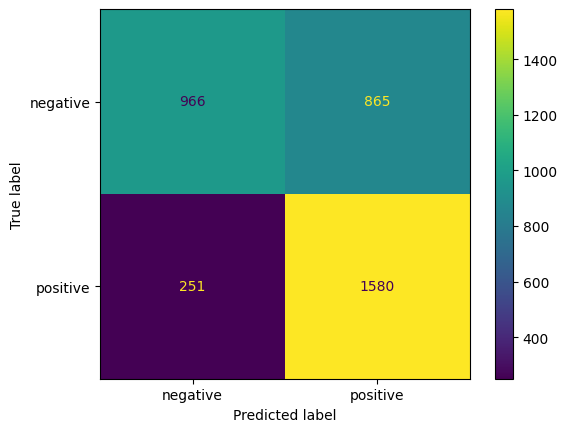

In [248]:
#@title Evaluate
exclude_neutral_sentiment_from_analyzer = sentiment_from_analyzer[sentiment_from_analyzer['sentiment'] != 'neutral']

print(classification_report(exclude_neutral_sentiment_from_analyzer['target_sentiment'], exclude_neutral_sentiment_from_analyzer['sentiment']))

cm = confusion_matrix(exclude_neutral_sentiment_from_analyzer['target_sentiment'], exclude_neutral_sentiment_from_analyzer['sentiment'])
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
cm_display.plot()

## Model training

### Logistic Regression model

In [249]:
logreg_model = LogisticRegression()
logreg_model.fit(x_train_vec, y_train)

logreg_model_predictions = logreg_model.predict(x_test_vec)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [250]:
print(classification_report(y_test, logreg_model_predictions))

              precision    recall  f1-score   support

    negative       0.73      0.70      0.72      2473
    positive       0.72      0.75      0.73      2527

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



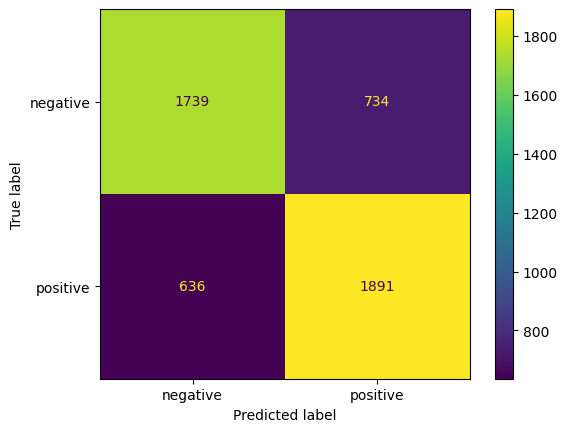

In [251]:
cm = confusion_matrix(y_test, logreg_model_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
cm_display.plot()

In [252]:
logreg_model_prob_prediction = logreg_model.predict_proba(x_test_vec)[:, 1]

logreg_model_sentiment_prediction = pd.DataFrame(columns=['text', 'score', 'target_sentiment', 'sentiment'])
logreg_model_sentiment_prediction['text'] = x_test_backup
logreg_model_sentiment_prediction['score'] = logreg_model_prob_prediction
logreg_model_sentiment_prediction['target_sentiment'] = y_test
logreg_model_sentiment_prediction['sentiment'] = logreg_model_sentiment_prediction['score'].apply(
      lambda x: 'strongly positive' if x > 0.80 else (
          'weakly positive' if x > 0.60 else (
              'neutral' if x > 0.40 else (
                  'weakly negative' if x > 0.20 else 'strongly negative'
                  )
              )
          )
    )

logreg_model_sentiment_prediction.sample(10)

,text,score,target_sentiment,sentiment
642212,@cherrydaily I will!!!! me and ben will come l...,0.839678,negative,strongly positive
1201115,"@JACKtheTRIPPER ur not following me me, thus i...",0.923143,positive,strongly positive
1213084,"@Peachiemoon yes, and it was awesome",0.916587,positive,strongly positive
595124,@garpods22 but we still aren't up there I don...,0.208505,negative,weakly negative
936523,(@canbernard) lol after i sent that last tweet...,0.741240,positive,weakly positive
1501963,@xxLOVExxPEACE hahahaha! im good ! you?,0.726593,positive,weakly positive
522281,@HamletDRC I have a knot in my stomach just fr...,0.417255,negative,neutral
1084333,tell all yr friends to follow me on twitter th...,0.977099,positive,strongly positive
663897,"Fuck you, allergies! I can hardly even hear be...",0.238771,negative,weakly negative
642376,"what a nice sunny day it is, shame i have to w...",0.370050,negative,weakly negative


### LSTM model

In [253]:
x_train_lstm = x_train_backup.copy()
x_test_lstm = x_test_backup.copy()

x_test_lstm.head(10)

595842     cpr fail day, i turned it off instead of shock...
304527     Laying in the bed because I just found out I'v...
787676     GRUMPY FUCK. i hate when people take there wee...
94473      @lolstephy pls just shutup about splendour n d...
698083     @chrisoldroyd Only UK? What about N. America  ...
515721     they added a new zodiac sign. i wanna be a sco...
1577992    Ooh... IE8 looks kinda flasher than 7, and it ...
1557765    snow snow snow snow snow snow snow snow snow y...
71941      right, been up half an hour, hang over is not ...
1317950    @da_evil ok,u work im gonna check vampire's news 
Name: text, dtype: object

In [254]:
x_train_lstm = x_train_lstm.apply(clean_text)
x_test_lstm = x_test_lstm.apply(clean_text)

x_train_lstm.head(10)

1473410    lace coming mango tree resturant last year pap...
1021177    yeah going freaking awesome upto much loveyouj...
958067              sure twitpic party picture give u detail
621438     oh shitttt there still ticket see demi lovato ...
1289024                      love wan na blog ill buy camera
1080438    okwhen text could ask post ur name account acc...
248279                       wish moment really missing babe
387726                                              headache
1460144           eagerly waiting twilight new moon twilight
1296714         link didnt display could repost correct link
Name: text, dtype: object

In [255]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train_lstm)
word_index = tokenizer.word_index

x_train_lstm_seq = tokenizer.texts_to_sequences(x_train_lstm)
x_train_lstm_pad = pad_sequences(x_train_lstm_seq, padding=padding_type, maxlen=max_length)

x_train_lstm_pad.shape

(15000, 200)

In [256]:
x_test_lstm_seq = tokenizer.texts_to_sequences(x_test_lstm)
x_test_lstm_pad = pad_sequences(x_test_lstm_seq, padding=padding_type, maxlen=max_length)

x_test_lstm_pad.shape

(5000, 200)

In [260]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
# lstm_model.add(SpatialDropout1D(0.4))
# lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dense(24, activation='relu'))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 100)          300000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 24)                3096      
                                                                 
 dense_19 (Dense)            (None, 2)                 50        
                                                                 
Total params: 387626 (1.48 MB)
Trainable params: 387626 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [258]:
y_train_backup = y_train.copy()
y_test_backup = y_test.copy()

label_encoder = LabelEncoder()
y_train_label_encoded = label_encoder.fit_transform(y_train)
y_train_label_onehot = to_categorical(y_train_label_encoded)

y_test_label_encoded = label_encoder.transform(y_test)
y_test_label_onehot = to_categorical(y_test_label_encoded)

y_train_label_onehot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [261]:
lstm_model.fit(x_train_lstm_pad, y_train_label_onehot, epochs=10, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 115s 259ms/step - loss: 0.5889 - accuracy: 0.6730 - val_loss: 0.5447 - val_accuracy: 0.7133
Epoch 2/10
422/422 [==============================] - 109s 258ms/step - loss: 0.4797 - accuracy: 0.7723 - val_loss: 0.5436 - val_accuracy: 0.7220
Epoch 3/10
422/422 [==============================] - 109s 259ms/step - loss: 0.4325 - accuracy: 0.7993 - val_loss: 0.5549 - val_accuracy: 0.7193
Epoch 4/10
422/422 [==============================] - 110s 261ms/step - loss: 0.3761 - accuracy: 0.8292 - val_loss: 0.5964 - val_accuracy: 0.7140
Epoch 5/10
422/422 [==============================] - 109s 257ms/step - loss: 0.3123 - accuracy: 0.8607 - val_loss: 0.6955 - val_accuracy: 0.7113
Epoch 6/10
422/422 [==============================] - 109s 259ms/step - loss: 0.2620 - accuracy: 0.8831 - val_loss: 0.9060 - val_accuracy: 0.7060
Epoch 7/10
422/422 [==============================] - 108s 256ms/step - loss: 0.2215 - accuracy: 0.9009 - val_loss: 0.9425 -

In [262]:
lstm_model.evaluate(x_test_lstm_pad, y_test_label_onehot)

157/157 [==============================] - 11s 70ms/step - loss: 1.5275 - accuracy: 0.6682


[1.5275145769119263, 0.6682000160217285]